In [1]:
# pip install spotipy 

# Imports

In [2]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Credentials

Credentials were stored in another file and I'm going to be importing them.

In [3]:
creds= pd.read_csv('../credentials')
SPOTIPY_CLIENT_ID = creds['Client ID'][0]
SPOTIPY_CLIENT_SECRET = creds['Client Secret'][0]
#Shameless redirect to my dance group lol 
SPOTIPY_REDIRECT_URI= 'https://www.ballethermosoamanecer.com/'
username = ""

# Data Collection 

## Testing 20 Songs in Liked 

In [4]:
client_credentials_manager = SpotifyClientCredentials(client_id= SPOTIPY_CLIENT_ID, 
                                                      client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager= client_credentials_manager)
scope = 'user-library-read playlist-read-private playlist-modify-public playlist-modify-private user-read-recently-played user-top-read'
token = util.prompt_for_user_token(username, scope, 
                                   client_id= SPOTIPY_CLIENT_ID, 
                                   client_secret= SPOTIPY_CLIENT_SECRET, 
                                   redirect_uri= SPOTIPY_REDIRECT_URI)
if token:
    
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_saved_tracks()
    count = 0
    total_liked_songs = results['total']
    for item in results['items']:
        track = item['track']
        print(track['name'] + ' - ' + track['artists'][0]['name'])
        count += 1
    print(f"\nShowing {count} out of {total_liked_songs} songs")
else:
    print("Can't get token for", username)

Payasos - Romeo Santos
Canalla - Romeo Santos
Propuesta Indecente - Romeo Santos
Inmortal - Aventura
Yo Perreo Sola - Bad Bunny
Pero Ya No - Bad Bunny
Atrévete - Nicky Jam
La Difícil - Bad Bunny
Rip It Up - Little Richard
Vete - Bad Bunny
A Través Del Vaso - Banda Los Sebastianes
La Santa - Bad Bunny
Cyanide - Metallica
Llegó el Bombero - Merenglass
La Muralla Verde - Los Enanitos Verdes
Salsa Con Coco - Pochy Y Su Cocoband
Un Millon De Primaveras - Vicente Fernández
Safaera - Bad Bunny
Soliá - Bad Bunny
Ignorantes - Bad Bunny

Showing 20 out of 1021 songs


Clealy my listening habits are... a little diverse. 

Shoutout to that new Bad Bunny album though haha 

## Collecting Audio Features for Liked Songs

In [5]:
song_name = []
song_uri = []
song_popularity = []
artist_name = []
artist_uri = []
genres_found = []
loops= 0 
track_audio_features = []
while results:
    for item in results['items']:
        track = item['track']
        song_name.append(track['name'])
        song_uri.append(track['uri'])
        song_popularity.append(track['popularity'])
    
        #Some songs have multuple artists so I'll make a list of artists as well as a list of uris for each song
        artist_name.append([artist['name'] for artist in track['artists']])
        artist_uri.append([artist['uri'] for artist in track['artists']])
    
        #Spotify doesn't provide the genre of the song so I have to look at the genre of the artist(s) of the song
        temp = sp.artists([artist['uri'] for artist in track['artists']])['artists']
        temp2 = []
        for temp_artists in temp:
            for genre in temp_artists['genres']:
                temp2.append(genre)
        #We only want to keep unique genres and avoid duplicate genres
        genres_found.append(list(set(temp2)))
    
    #Collecting audio features available for each song 
    #As shown from above, 20 
    track_audio_features.extend(sp.audio_features(song_uri[20*loops :20*(loops+1)]))
    print(f'Audio Features were gathered for {len(track_audio_features)} songs')

    loops += 1 
    results = sp.next(results)
    if (loops % 5) == 0 :
        print(f'{loops} cycles have been completed\n')
    #Sleep in order to not bombard with too many requests
    time.sleep(.8)

#Bringing it all together 
df_audio_feat = pd.DataFrame(track_audio_features) 
df_tracks = pd.DataFrame({'artist_uri': artist_uri,
                          'song_uri': song_uri,
                          'song_name':song_name,
                          'artists': artist_name,
                          'genres': genres_found,
                          'popularity': song_popularity})

print("\nCreating Dataframe . . .")
collected_data = pd.merge(df_tracks, df_audio_feat, left_on= 'song_uri', right_on= 'uri')
                          

Audio Features were gathered for 20 songs
Audio Features were gathered for 40 songs
Audio Features were gathered for 60 songs
Audio Features were gathered for 80 songs
Audio Features were gathered for 100 songs
5 cycles have been completed

Audio Features were gathered for 120 songs
Audio Features were gathered for 140 songs
Audio Features were gathered for 160 songs
Audio Features were gathered for 180 songs
Audio Features were gathered for 200 songs
10 cycles have been completed

Audio Features were gathered for 220 songs
Audio Features were gathered for 240 songs
Audio Features were gathered for 260 songs
Audio Features were gathered for 280 songs
Audio Features were gathered for 300 songs
15 cycles have been completed

Audio Features were gathered for 320 songs
Audio Features were gathered for 340 songs
Audio Features were gathered for 360 songs
Audio Features were gathered for 380 songs
Audio Features were gathered for 400 songs
20 cycles have been completed

Audio Features were g

In [6]:
collected_data.head()

,artist_uri,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,"[spotify:artist:5lwmRuXgjX8xIwlnauTZIP, spotif...",spotify:track:1soECbw2IFdWt5W8Rb4uG7,Payasos,"[Romeo Santos, Frank Reyes]","[bachata, tropical, dominican pop, latin]",64,0.855,0.698,10,-4.511,...,0.3470,0.906,124.057,audio_features,1soECbw2IFdWt5W8Rb4uG7,spotify:track:1soECbw2IFdWt5W8Rb4uG7,https://api.spotify.com/v1/tracks/1soECbw2IFdW...,https://api.spotify.com/v1/audio-analysis/1soE...,203427,4
1,"[spotify:artist:5lwmRuXgjX8xIwlnauTZIP, spotif...",spotify:track:4XEXrp37kZXpQTB2r5vWbS,Canalla,"[Romeo Santos, El Chaval de la Bachata]","[bachata, tropical, latin]",66,0.878,0.875,11,-1.457,...,0.1450,0.902,130.027,audio_features,4XEXrp37kZXpQTB2r5vWbS,spotify:track:4XEXrp37kZXpQTB2r5vWbS,https://api.spotify.com/v1/tracks/4XEXrp37kZXp...,https://api.spotify.com/v1/audio-analysis/4XEX...,225387,4
2,[spotify:artist:5lwmRuXgjX8xIwlnauTZIP],spotify:track:6FwEmbPo3d3USlMzuulT69,Propuesta Indecente,[Romeo Santos],"[bachata, tropical, latin]",13,0.760,0.650,2,-5.819,...,0.0737,0.782,122.948,audio_features,6FwEmbPo3d3USlMzuulT69,spotify:track:6FwEmbPo3d3USlMzuulT69,https://api.spotify.com/v1/tracks/6FwEmbPo3d3U...,https://api.spotify.com/v1/audio-analysis/6FwE...,235227,4
3,[spotify:artist:1qto4hHid1P71emI6Fd8xi],spotify:track:2swZ0X1njeU32SNJeBKIfW,Inmortal,[Aventura],"[latin, latin pop, tropical, latin hip hop, ba...",71,0.770,0.775,8,-4.650,...,0.0651,0.848,124.015,audio_features,2swZ0X1njeU32SNJeBKIfW,spotify:track:2swZ0X1njeU32SNJeBKIfW,https://api.spotify.com/v1/tracks/2swZ0X1njeU3...,https://api.spotify.com/v1/audio-analysis/2swZ...,256440,4
4,[spotify:artist:4q3ewBCX7sLwd24euuV69X],spotify:track:0SqqAgdovOE24BzxIClpjw,Yo Perreo Sola,[Bad Bunny],"[trap latino, reggaeton, latin]",87,0.860,0.758,11,-5.160,...,0.3440,0.453,97.014,audio_features,0SqqAgdovOE24BzxIClpjw,spotify:track:0SqqAgdovOE24BzxIClpjw,https://api.spotify.com/v1/tracks/0SqqAgdovOE2...,https://api.spotify.com/v1/audio-analysis/0Sqq...,172127,4


Alright, now there are two options. 

Ideally, I want to create playlists for each genre and place the correct songs into each playlist. Given that some songs can be classified under multiple genres (since we're using the artist's genere as a proxy), it might be difficult to classify songs into genre's that spotify has provided. In addition, genres are waaaaay too specific for my needs. To start, I will simplify my problem and try classying my music into larger, umbrella genres. I will also explore KMeans clustering in order to see how many realistic clusters can be formed. I will use PCA in order to reduce dimensionality and see if that improves the KMeans. I will repeat the processes with DBSCAN and see if there are any improvements as well as noticable outliers. 


# Data Cleaning

## Outliers and  `null` values

We have some data cleaning to do before I can use my data. Let's check for `null` values and remove columns that are repetitive and provide no additional information. Domain knowledge usually helps identify any outliers or data points that might be off due to human error but for this case, I will assume all values provided by Spotify are normal. 

In [7]:
collected_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 0 to 1020
Data columns (total 24 columns):
artist_uri          1021 non-null object
song_uri            1021 non-null object
song_name           1021 non-null object
artists             1021 non-null object
genres              1021 non-null object
popularity          1021 non-null int64
danceability        1021 non-null float64
energy              1021 non-null float64
key                 1021 non-null int64
loudness            1021 non-null float64
mode                1021 non-null int64
speechiness         1021 non-null float64
acousticness        1021 non-null float64
instrumentalness    1021 non-null float64
liveness            1021 non-null float64
valence             1021 non-null float64
tempo               1021 non-null float64
type                1021 non-null object
id                  1021 non-null object
uri                 1021 non-null object
track_href          1021 non-null object
analysis_url        1021 n

In [8]:
collected_data.isnull().sum()

artist_uri          0
song_uri            0
song_name           0
artists             0
genres              0
popularity          0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
type                0
id                  0
uri                 0
track_href          0
analysis_url        0
duration_ms         0
time_signature      0
dtype: int64

## Dropping Unecessary Columns

In [9]:
data= collected_data.drop(columns= ['artist_uri', 'type','id', 'uri', 'track_href', 'analysis_url'])
data

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,spotify:track:1soECbw2IFdWt5W8Rb4uG7,Payasos,"[Romeo Santos, Frank Reyes]","[bachata, tropical, dominican pop, latin]",64,0.855,0.698,10,-4.511,0,0.0447,0.245,0.000000,0.3470,0.906,124.057,203427,4
1,spotify:track:4XEXrp37kZXpQTB2r5vWbS,Canalla,"[Romeo Santos, El Chaval de la Bachata]","[bachata, tropical, latin]",66,0.878,0.875,11,-1.457,0,0.0453,0.148,0.000000,0.1450,0.902,130.027,225387,4
2,spotify:track:6FwEmbPo3d3USlMzuulT69,Propuesta Indecente,[Romeo Santos],"[bachata, tropical, latin]",13,0.760,0.650,2,-5.819,1,0.0512,0.514,0.000000,0.0737,0.782,122.948,235227,4
3,spotify:track:2swZ0X1njeU32SNJeBKIfW,Inmortal,[Aventura],"[latin, latin pop, tropical, latin hip hop, ba...",71,0.770,0.775,8,-4.650,0,0.0349,0.178,0.000000,0.0651,0.848,124.015,256440,4
4,spotify:track:0SqqAgdovOE24BzxIClpjw,Yo Perreo Sola,[Bad Bunny],"[trap latino, reggaeton, latin]",87,0.860,0.758,11,-5.160,1,0.0695,0.021,0.000065,0.3440,0.453,97.014,172127,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,spotify:track:0HDHY6RSHHG2ZTE0cMT4GJ,Los Infieles,[Aventura],"[latin, latin pop, tropical, latin hip hop, ba...",69,0.745,0.716,9,-8.221,0,0.0411,0.202,0.000000,0.0590,0.817,132.932,257187,4
1017,spotify:track:2XYkvc4UWMO9U2iQcIjJe7,Te Extraño - Bachata Version,[Xtreme],"[bachata, tropical, latin]",2,0.793,0.592,6,-4.749,0,0.0344,0.760,0.000000,0.0876,0.892,129.960,213973,4
1018,spotify:track:0wDEs6WvqDHq4XJZC0dHhO,Hoja En Blanco,"[Monchy & Alexandra, Alexandra]","[bachata, tropical, latin]",63,0.932,0.772,0,-3.599,1,0.0369,0.225,0.000003,0.1760,0.863,135.063,307200,4
1019,spotify:track:6I86RF3odBlcuZA9Vfjzeq,Eres Mía,[Romeo Santos],"[bachata, tropical, latin]",72,0.843,0.729,6,-3.634,0,0.0374,0.401,0.000001,0.2060,0.903,123.046,250640,4


## Checking for Duplicates 

In [10]:
data[data.duplicated(subset=['song_uri'])]

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature


No duplicates found

## Simplifying Generes (Manually) 

Lets see what genres we have:

In [11]:
genre_dummied = data['genres'].str.join(sep='*').str.get_dummies(sep='*')
genre_dummied

,adult standards,african percussion,afro dancehall,afropop,album rock,alternative dance,alternative metal,alternative r&b,alternative rock,argentine hip hop,...,venezuelan rock,veracruz indie,viral pop,vocal jazz,welsh metal,west coast rap,world worship,worship,wrestling,yacht rock
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In theory, I would have 371 different playlists if I made a playlist for each genre. That's excessive and unproductive since some songs pertain to multiple genres and some genres only have one song associated with it. Lets add up our genres and see what's popular in my liked songs 

In [12]:
genre_dummied.sum().sort_values(ascending= False)

latin               362
tropical            237
reggaeton           228
latin hip hop       141
latin pop           135
                   ... 
lgbtq+ hip hop        1
kids dance party      1
jazz guitar           1
irish hip hop         1
lounge                1
Length: 370, dtype: int64

Given that `latin` is the most common genere, I will go back to `data` and check if any `latin` is in the list of generes. I will replace the list with `latin` in order to simplfy my process. There are multiple subgeneres like, cumbia, bachata, merenguem etc. but for the initial phase, I am focusing on latin or not latin.

--------
After initial EDA, I have to modify my problem since my songs are overwhelmingly Hispanic. I made subdivisions of the different subgenres within Hispanic music. Not as accurate but this is how I distinguish my own music tastes and this is how I want my playlists to be organized by (for the most part). I notcied that some artists do not have a genre associated with them so lets figure out why and what to do with these values 

In [13]:
bachata_salsa_merengue = {'porro','bachata', 'merengue','salsa', 'salsa peruana', 'tropical', 'timba', 'cuban rumba','dominican pop'}
artists_bsm = []

cumbia_and_mexican = {'trival','cumbia','cumbia salvadorena','gruperas inmortales' ,'cumbia villera', 
                      'cumbia sonidera', 'tejano', 'guaracha', 'cumbia paraguaya','nu-cumbia','deep cumbia sonidera', 
                      'grupera','tamborazo','banda', 'ranchera', 'mariachi', 'duranguense', 
                      'cancion melodica', 'norteno-sax','regional mexican','regional mexican pop'}
artists_cam = []

latin_reggaeton = {'rap dominicano','perreo','venezuelan hip hop','chilean hardcore','reggaeton', 
                   'dembow', 'trap latino', 'latin hip hop','panamanian pop','venezuelan indie',
                   'latin pop', 'mexican edm', 'pop romantico', 'reggaeton flow', 'colombian pop','electro latino',
                   'puerto rican pop'}
artists_lat_reg = []

not_hispanic = {'escape room','christian music','shimmer pop','bass trap', 'indie folk', 'stomp and holler',
                'emo rap','indie pop','indie soul', 'edm', 'house', 
                'british soul', 'disco', 'funk','la pop','uk hip hop',
                'social media pop','afropop','reggae fusion','ghanaian pop','soca',
                'hip hop','pop rap', 'pop', 'hip pop', 'rap', 'chicago rap','chicago pop', 
                'meme rap', 'dancehall', 'outlaw country', 'contemporary country','indietronica', 
                'indie poptimism', 'vapor twitch','electropop', 'vapor soul','tropical house'}
artists_not_his = []

rock = {'mexican rock', 'rock en espanol', 'latin rock', 'mexican rock-and-roll',
        'metalcore','screamo','rock', 'rock-and-roll', 'punk', 'alternative metal', 
        'soft rock', 'glam rock', 'piano rock'}
artists_rock = []

empty_index = []


In [14]:
simplified_genres = []
for i in range(len(genres_found)):
    counter_a = len(not_hispanic & set(genres_found[i]))
    counter_b = len(rock & set(genres_found[i]))
    counter_c = len(cumbia_and_mexican & set(genres_found[i]))
    counter_d = len(bachata_salsa_merengue  & set(genres_found[i]))
    counter_e = len(latin_reggaeton & set(genres_found[i]))

    count_max = max([counter_a, counter_b, counter_c, counter_d, counter_e])
    
    if count_max == 0:
        simplified_genres.append('Empty')
        empty_index.append(i)
        
    elif count_max == counter_a:    
        simplified_genres.append('Non Hispanic')
        artists_not_his.extend(artist_name[i])
        
    elif count_max == counter_b:
        simplified_genres.append('Rock')
        artists_rock.extend(artist_name[i])

        
    elif count_max == counter_c:
        simplified_genres.append('Cumbia y Musica Mexicana')
        artists_cam.extend(artist_name[i])
       
    elif count_max == counter_d:
        simplified_genres.append('Bachata Salsa y Merengue')
        artists_bsm.extend(artist_name[i])

    elif count_max == counter_e:
        simplified_genres.append('Reggaeton and Latin Pop')
        artists_lat_reg.extend(artist_name[i])



data['simplified_genre'] = simplified_genres

In [15]:
genre_dummied = data['simplified_genre'].str.get_dummies()
genre_dummied

,Bachata Salsa y Merengue,Cumbia y Musica Mexicana,Empty,Non Hispanic,Reggaeton and Latin Pop,Rock
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,1,0,0,0,0,0
3,1,0,0,0,0,0
4,0,0,0,0,1,0
...,...,...,...,...,...,...
1016,1,0,0,0,0,0
1017,1,0,0,0,0,0
1018,1,0,0,0,0,0
1019,1,0,0,0,0,0


In [16]:
genre_dummied.sum().sort_values(ascending= False) 

Cumbia y Musica Mexicana    315
Reggaeton and Latin Pop     231
Non Hispanic                205
Rock                        120
Bachata Salsa y Merengue     82
Empty                        68
dtype: int64

Looks like there are some artists that do not have genre data. I'm not sure why that is but since we used a list, it would not have appeared as a null value. Lets check out what `Empty` genre looks like

In [17]:
data[data['simplified_genre'] == 'Empty'][15:20]

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,simplified_genre
265,spotify:track:52sZNRR4J84hZAi7nULUS1,Ojitos Mentirosos,[A Mover La Colita Cumbias],[],20,0.746,0.657,10,-7.386,1,0.0557,0.3760,0.000007,0.1500,0.966,103.925,193515,4,Empty
267,spotify:track:1F4gMWj2Wu6Vww46MOl26V,La Mujer del Pelotero,[Merenglass Grupo],[],55,0.887,0.913,9,-2.867,1,0.0639,0.3460,0.001660,0.0649,0.965,150.044,198560,4,Empty
273,spotify:track:6bGYUzH3Cv74Skv4J0QQGR,Corazon Enamorado,[La Conga],[],30,0.645,0.746,9,-2.979,0,0.1850,0.3530,0.000313,0.0651,0.685,176.941,215453,4,Empty
284,spotify:track:1cXHJnw8YvkOygZCCiTbSQ,Mil Horas,[Sonora Dinamica De Colombia],[],0,0.855,0.457,0,-12.351,1,0.0512,0.0129,0.006780,0.0689,0.837,99.983,231187,4,Empty
288,spotify:track:5LNYnwMBaqUkNmTiPbRsoY,Fuiste Mala,"[A.B. Quintanilla III Y Los Kumbia Kings, Rica...",[],51,0.682,0.742,0,-3.383,0,0.0477,0.3940,0.000000,0.1680,0.915,172.019,198213,4,Empty


Oh man, it looks like I will have to manually assign them to categories. Let the listening begin. I'll reassign the simplfied genres to make sure we have no more empty. I will also add the artists to their respective artists list in case I need to use it in the future. 


After this, I'll make playlists based on some machine learning models. The bright side is that since I'm only concerned with Hispanic genres, anything with an english title will be placed into non-hispanic. 

In [18]:
artists_bsm.extend(['Kalimete','Merenglass', 'Merenglass Grupo', 'Célia', 'Jeyro', 'Judy Santos', 
                    'Orquesta los Adolecente', 'Orquesta Noche Sabrosa'])
artists_cam.extend(['Grupo Dinastia Mendoza', 'Nuevo Nivel Norteño', 'Grupo Firme', 
                    'Banda Coloso','La Atrevida Banda Sierra Blanca','Grupo Novedoso',
                    'Super Máquina Musical de Guerrero', 'Sonora Dinamica De Colombia',
                    'La Conga', 'A.B. Quintanilla III Y Los Kumbia Kings', 'Ricardo Muñoz',
                    'Sonador', 'Control', 'El Amigable De Tijuana', 'Tornado','La Hija Del Mariachi',
                    'Ángela Aguilar', 'Los Kiero', 'Banda El RetoÑo', 'Grupo Kual? Dinastia Pedraza',
                    'A Mover La Colita Cumbias', "Los Karkik's" ])
artists_lat_reg.extend(['Jenn', 'Tatiana Hazel', 'Danny Daniel','La Montra' ,'Dj Worldwide', 
                        'John Jairo & Dj Ewduarmix'])
artists_not_his.extend(['Hvrbie', 'Franklyn Watts', 'Rhiannon Roze', 'Homestead', 
                        'Chris Jobe', 'Tim Gent', 'Finatticz', 'YUNGHELLBOY', "Jo'el Monroe", 
                        'La Doña','TITUS', 'Jay Pharoah', 'Myles William', 'RØYLS', 'Ashley Clark',
                        'D Nilsz', 'K.P. & Envyi', ])
# artists_rock.extend([]) No rock music found in empty genre 

In [19]:
for index in empty_index:
    counter_a = len(set(data.loc[index, 'artists']) & set(artists_bsm))
    counter_b = len(set(data.loc[index, 'artists']) & set(artists_cam))
    counter_c = len(set(data.loc[index, 'artists']) & set(artists_lat_reg))
    counter_d = len(set(data.loc[index, 'artists']) & set(artists_not_his))
    counter_e = len(set(data.loc[index, 'artists']) & set(artists_rock))
    count_max = max([counter_a, counter_b, counter_c, counter_d, counter_e])
    
    if count_max == 0:
        data.loc[index, 'simplified_genre'] = 'Still Empty'
        
    elif count_max == counter_a:  
        data.loc[index, 'simplified_genre'] = 'Bachata Salsa y Merengue'
        
    elif count_max == counter_b:
        data.loc[index, 'simplified_genre'] = 'Cumbia y Musica Mexicana'
        simplified_genres.append('Rock')
        artists_rock.extend(artist_name[i])

        
    elif count_max == counter_c:
        data.loc[index, 'simplified_genre'] = 'Latin Pop and Regg'

       
    elif count_max == counter_d:
        data.loc[index, 'simplified_genre'] = 'Non Hispanic'

    elif count_max == counter_e:
        data.loc[index, 'simplified_genre'] = 'Rock'
        
    

This is the following compostion of my liked music. I will make playlists based on these manually selected Genres

In [20]:
data['simplified_genre'].value_counts(normalize = True)

Cumbia y Musica Mexicana    0.347698
Reggaeton and Latin Pop     0.226249
Non Hispanic                0.213516
Rock                        0.117532
Bachata Salsa y Merengue    0.089128
Latin Pop and Regg          0.005877
Name: simplified_genre, dtype: float64

In [21]:
data['simplified_genre'].value_counts()

Cumbia y Musica Mexicana    355
Reggaeton and Latin Pop     231
Non Hispanic                218
Rock                        120
Bachata Salsa y Merengue     91
Latin Pop and Regg            6
Name: simplified_genre, dtype: int64

# Playlist Creations

## Playlists (Manual Simplification) 

In [22]:
# # HOW TO REMOVE A PLAYLIST
# for l in sp.current_user_playlists()['items']: 
#     if l['name'] in playlist_genres: 
#         sp.user_playlist_unfollow(user= sp.me()['id'], playlist_id= l['id'])

In [23]:
playlist_genres = set(data['simplified_genre'])
myself = sp.me()['id']
current_playlist_names = []
for l in sp.current_user_playlists()['items']: 
    current_playlist_names.append(l['name'])


In [24]:
for i in playlist_genres: 
    if i not in current_playlist_names:
        playlist_name = i
        description = f'Using Python to Manually Sort Liked Songs pertaining to "{i}" genres'
        ls_songs_uri = list(data[data['simplified_genre'] == i]['song_uri'])
        playlist = sp.user_playlist_create(user= myself, name = playlist_name, description= description)
        current_playlist_names.append(playlist['name'])
        print(f'{playlist} has been created')
        play_id = playlist['id']
        loops = (len(ls_songs_uri) // 50) + 1
        for k in range(loops):
            print('attempting')
            print(f'adding songs from {50*k} to {50*k+1}')
            sp.user_playlist_add_tracks(user = myself, playlist_id= play_id, tracks= ls_songs_uri[(50*k) : (50 *(k+1))])
            print('done')



## Playlists (Using KMeans) 

In [25]:
#only want to keep numeric values
X = data.drop(columns= ['song_uri', 'song_name','artists','genres', 'simplified_genre'])
#scaling everything since KMeans is sensitive to distance
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [26]:
km = KMeans(n_clusters=5, random_state=42)
km.fit(X_sc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [27]:
km.labels_

array([3, 3, 2, ..., 2, 3, 3], dtype=int32)

In [28]:
data['Kmeans_cluster'] = km.labels_
data

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,simplified_genre,Kmeans_cluster
0,spotify:track:1soECbw2IFdWt5W8Rb4uG7,Payasos,"[Romeo Santos, Frank Reyes]","[bachata, tropical, dominican pop, latin]",64,0.855,0.698,10,-4.511,0,0.0447,0.245,0.000000,0.3470,0.906,124.057,203427,4,Bachata Salsa y Merengue,3
1,spotify:track:4XEXrp37kZXpQTB2r5vWbS,Canalla,"[Romeo Santos, El Chaval de la Bachata]","[bachata, tropical, latin]",66,0.878,0.875,11,-1.457,0,0.0453,0.148,0.000000,0.1450,0.902,130.027,225387,4,Bachata Salsa y Merengue,3
2,spotify:track:6FwEmbPo3d3USlMzuulT69,Propuesta Indecente,[Romeo Santos],"[bachata, tropical, latin]",13,0.760,0.650,2,-5.819,1,0.0512,0.514,0.000000,0.0737,0.782,122.948,235227,4,Bachata Salsa y Merengue,2
3,spotify:track:2swZ0X1njeU32SNJeBKIfW,Inmortal,[Aventura],"[latin, latin pop, tropical, latin hip hop, ba...",71,0.770,0.775,8,-4.650,0,0.0349,0.178,0.000000,0.0651,0.848,124.015,256440,4,Bachata Salsa y Merengue,3
4,spotify:track:0SqqAgdovOE24BzxIClpjw,Yo Perreo Sola,[Bad Bunny],"[trap latino, reggaeton, latin]",87,0.860,0.758,11,-5.160,1,0.0695,0.021,0.000065,0.3440,0.453,97.014,172127,4,Reggaeton and Latin Pop,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,spotify:track:0HDHY6RSHHG2ZTE0cMT4GJ,Los Infieles,[Aventura],"[latin, latin pop, tropical, latin hip hop, ba...",69,0.745,0.716,9,-8.221,0,0.0411,0.202,0.000000,0.0590,0.817,132.932,257187,4,Bachata Salsa y Merengue,3
1017,spotify:track:2XYkvc4UWMO9U2iQcIjJe7,Te Extraño - Bachata Version,[Xtreme],"[bachata, tropical, latin]",2,0.793,0.592,6,-4.749,0,0.0344,0.760,0.000000,0.0876,0.892,129.960,213973,4,Bachata Salsa y Merengue,3
1018,spotify:track:0wDEs6WvqDHq4XJZC0dHhO,Hoja En Blanco,"[Monchy & Alexandra, Alexandra]","[bachata, tropical, latin]",63,0.932,0.772,0,-3.599,1,0.0369,0.225,0.000003,0.1760,0.863,135.063,307200,4,Bachata Salsa y Merengue,2
1019,spotify:track:6I86RF3odBlcuZA9Vfjzeq,Eres Mía,[Romeo Santos],"[bachata, tropical, latin]",72,0.843,0.729,6,-3.634,0,0.0374,0.401,0.000001,0.2060,0.903,123.046,250640,4,Bachata Salsa y Merengue,3


In [29]:
scores = []
for k in range(2, 51):
    cl = KMeans(n_clusters=k)
    cl.fit(X_sc)
    inertia = cl.inertia_
    sil = silhouette_score(X_sc, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

In [30]:
score_df.head()

,k,inertia,silhouette
0,2,12920.498875,0.126861
1,3,12030.485378,0.136659
2,4,11364.784133,0.095906
3,5,10537.002849,0.102872
4,6,10052.968107,0.099868


Text(0.5, 1.0, 'Silhouette Score over k')

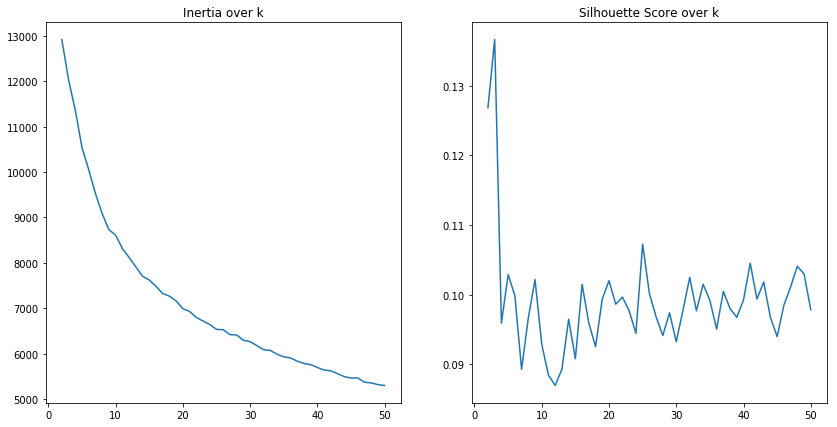

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

Based on these graphs, I can conclude that KMeans is not suitable because you would be able to see a sharp decrease and then a flattening out. There is no "elbow" in the inertia plot. The sharp decrease is seen in the silhouette score but the silhouette score is so low, KMeans is not useful for identifying clusters in this dataset. We will have to explore other options. 

## Playlists (Using KMeans) - Including PCA

In [32]:
pca = PCA(n_components= 3)
pca.fit(X_sc)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [33]:
new_X = pca.transform(X_sc)

In [34]:
pca_km = KMeans(n_clusters=5, random_state=42)
pca_km.fit(new_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [35]:
data['Kmeans_cluster_pca'] = pca_km.labels_
data

,song_uri,song_name,artists,genres,popularity,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,simplified_genre,Kmeans_cluster,Kmeans_cluster_pca
0,spotify:track:1soECbw2IFdWt5W8Rb4uG7,Payasos,"[Romeo Santos, Frank Reyes]","[bachata, tropical, dominican pop, latin]",64,0.855,0.698,10,-4.511,0,...,0.245,0.000000,0.3470,0.906,124.057,203427,4,Bachata Salsa y Merengue,3,3
1,spotify:track:4XEXrp37kZXpQTB2r5vWbS,Canalla,"[Romeo Santos, El Chaval de la Bachata]","[bachata, tropical, latin]",66,0.878,0.875,11,-1.457,0,...,0.148,0.000000,0.1450,0.902,130.027,225387,4,Bachata Salsa y Merengue,3,3
2,spotify:track:6FwEmbPo3d3USlMzuulT69,Propuesta Indecente,[Romeo Santos],"[bachata, tropical, latin]",13,0.760,0.650,2,-5.819,1,...,0.514,0.000000,0.0737,0.782,122.948,235227,4,Bachata Salsa y Merengue,2,4
3,spotify:track:2swZ0X1njeU32SNJeBKIfW,Inmortal,[Aventura],"[latin, latin pop, tropical, latin hip hop, ba...",71,0.770,0.775,8,-4.650,0,...,0.178,0.000000,0.0651,0.848,124.015,256440,4,Bachata Salsa y Merengue,3,3
4,spotify:track:0SqqAgdovOE24BzxIClpjw,Yo Perreo Sola,[Bad Bunny],"[trap latino, reggaeton, latin]",87,0.860,0.758,11,-5.160,1,...,0.021,0.000065,0.3440,0.453,97.014,172127,4,Reggaeton and Latin Pop,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016,spotify:track:0HDHY6RSHHG2ZTE0cMT4GJ,Los Infieles,[Aventura],"[latin, latin pop, tropical, latin hip hop, ba...",69,0.745,0.716,9,-8.221,0,...,0.202,0.000000,0.0590,0.817,132.932,257187,4,Bachata Salsa y Merengue,3,0
1017,spotify:track:2XYkvc4UWMO9U2iQcIjJe7,Te Extraño - Bachata Version,[Xtreme],"[bachata, tropical, latin]",2,0.793,0.592,6,-4.749,0,...,0.760,0.000000,0.0876,0.892,129.960,213973,4,Bachata Salsa y Merengue,3,4
1018,spotify:track:0wDEs6WvqDHq4XJZC0dHhO,Hoja En Blanco,"[Monchy & Alexandra, Alexandra]","[bachata, tropical, latin]",63,0.932,0.772,0,-3.599,1,...,0.225,0.000003,0.1760,0.863,135.063,307200,4,Bachata Salsa y Merengue,2,3
1019,spotify:track:6I86RF3odBlcuZA9Vfjzeq,Eres Mía,[Romeo Santos],"[bachata, tropical, latin]",72,0.843,0.729,6,-3.634,0,...,0.401,0.000001,0.2060,0.903,123.046,250640,4,Bachata Salsa y Merengue,3,3


In [36]:
scores = []
for k in range(2, 51):
    cl = KMeans(n_clusters=k)
    cl.fit(new_X)
    inertia = cl.inertia_
    sil = silhouette_score(new_X, cl.labels_)
    scores.append([k, inertia, sil])
    
score_df = pd.DataFrame(scores)
score_df.columns = ['k', 'inertia', 'silhouette']

In [37]:
score_df.head()

,k,inertia,silhouette
0,2,3904.686639,0.286316
1,3,3091.709110,0.269590
2,4,2506.842289,0.258021
3,5,2212.899200,0.243455
4,6,1963.887662,0.245688


Text(0.5, 1.0, 'Silhouette Score over k')

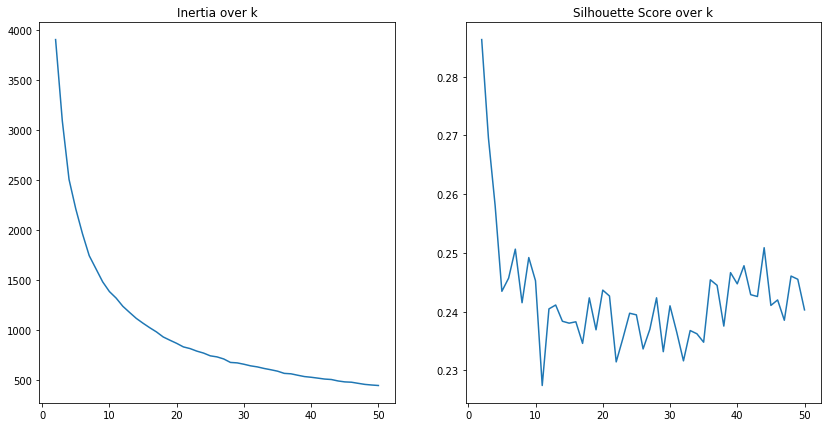

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].plot(score_df.k, score_df.inertia)
axes[0].set_title('Inertia over k')
axes[1].plot(score_df.k, score_df.silhouette);
axes[1].set_title('Silhouette Score over k')

In [39]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 3 components): {np.round(var_exp[:3],3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 3 components): {np.round(cum_var_exp[:3],3)}')

Explained variance (first 3 components): [0.153 0.114 0.102]

Cumulative explained variance (first 3 components): [0.153 0.267 0.368]


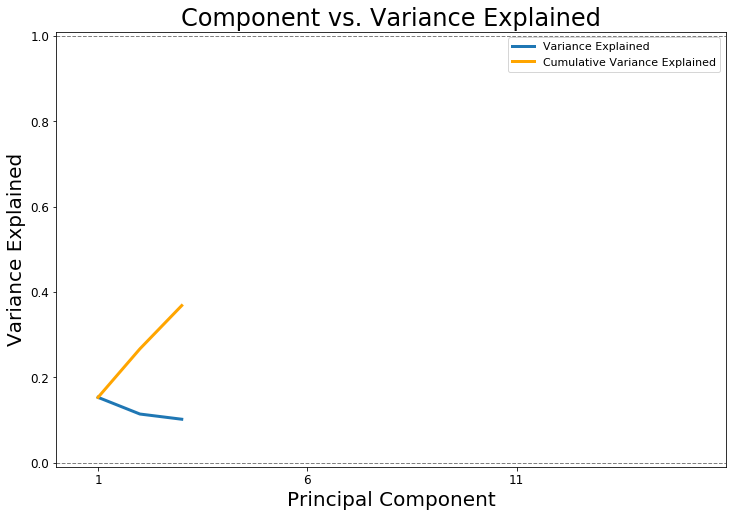

In [40]:
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,15])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 15, 5), range(1, 15, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

PCA isn't really useful since we need more than three components to explain most of the variance. Although the silhouette score improved, only 36.8% of the variance is explained by our model. This confirmed that we definitely need to use another type of clustering algorithm 

## Playlists (Using DBSCAN) 

In [41]:
#scaling everything since DBSCAN is sensitive to distance
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [42]:
dbscan = DBSCAN(eps= 6, min_samples= 1)
dbscan.fit(X_sc);
set(dbscan.labels_)

{0, 1, 2, 3}

In [43]:
silhouette_score(X_sc, dbscan.labels_)

0.4949607087334847

In [44]:
dbscan = DBSCAN(eps= 6.7, min_samples= 1)
dbscan.fit(X_sc);
set(dbscan.labels_)

{0, 1}

In [45]:
silhouette_score(X_sc, dbscan.labels_)

0.5461899544466523

In [46]:
dbscan = DBSCAN(eps= 3, min_samples= 2)
dbscan.fit(X_sc);
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7}

In [47]:
silhouette_score(X_sc, dbscan.labels_)

0.09124910243118385

In [48]:
dbscan = DBSCAN(eps= 2, min_samples= 5)
dbscan.fit(X_sc);
set(dbscan.labels_)

{-1, 0, 1, 2, 3, 4}

In [49]:
silhouette_score(X_sc, dbscan.labels_)

-0.07251670279116898

I need to find a systemic way to test various combinations and find the optimal hyperparameters 